In [167]:
import skimage
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import gaussian_filter
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy.optimize import curve_fit
import statistics



stack=io.imread(r'C:\Users\adria\Desktop\Master\SerialCLEM\stack.tif')

# microscope magnification
mag = 97.33

# physical pixel size of microscope in nm
phys_pix_size = 3450

# actual average bead size in nm
bead_size = 200

# digital pixel size in nm
digi_pix_size = phys_pix_size/mag

# the sigma used in all gaussian/LoG processing - size of a bead in pixels
sigma_Gl = bead_size/digi_pix_size

# the radius to exclude any bigger fluorescent particles (bead radius = sqrt(2)*sigma) not sigma_Gl
excl_fac = sqrt(2)

# preprocessing - gaussian filtering is done at approximate bead size-> filtering_factor*sigma_Gl
filt_fac = 0.75

# filtering factor to extract the image gradient
# higher factors are more conservative, but will remove less gradient
grad_filt_fac = 50

In [168]:
#take projection of highest value, and correct it by removing gradient and blurring it
max_proj= np.max(stack, axis=0)
max_proj = max_proj/np.max(max_proj)

gradient_image = scipy.ndimage.gaussian_filter(max_proj, sigma_Gl * grad_filt_fac)

mean_grad = np.mean(gradient_image)

corrected_image = max_proj - gradient_image + mean_grad

max_value = np.max(corrected_image)

corrected_image = corrected_image/max_value

corr_img_gauss = scipy.ndimage.gaussian_filter(corrected_image, filt_fac * sigma_Gl)

In [169]:
# extract regions of interest with laplacian of gaussian

rois = skimage.feature.blob_log(corr_img_gauss, min_sigma=sigma_Gl*sqrt(2)/2, max_sigma=sigma_Gl*sqrt(2), num_sigma=40,
                                threshold=0.01, exclude_border=True)

mean_corr_img_gauss = np.mean(corr_img_gauss)
subpicture_G_median = np.median(corr_img_gauss)

In [170]:
# function to find the perfect parameter for the step later which excludes rois that have bright surroundings
# fits a sigmoid function through the "parameter vs remaining rois" plot and then takes the inflection point as perfect parameter
# it essetially removes approx half the points which have the brightest surroundings
#may lead to issues when the proportion of beads vs cells is very skewed
param_range = np.linspace(0.75, 1.25, 400)

outs = []

for j in param_range:
    rois2 = []
    for i in range(len(rois)):
        r = round(excl_fac * sigma_Gl)

        if rois[i,0]+r < corr_img_gauss.shape[0] and rois[i, 0]-r > 0 and rois[i, 1]+r < corr_img_gauss.shape[1] and rois[i, 1]-r > 0:
            sub_M = max_proj[round(rois[i, 0] - r):round(rois[i, 0] + r), round(rois[i, 1] - r):round(rois[i, 1] + r)]
            sub_M2 = max_proj[round(rois[i, 0] - 2 * r / 3):round(rois[i, 0] + 2 * r / 3), round(rois[i, 1] - 2 * r / 3):round(rois[i, 1] + 2 * r / 3)]

            sub_M_shape = sub_M.shape
            sub_M2_shape = sub_M2.shape

            sub_M_ring_mean = (np.sum(sub_M)-np.sum(sub_M2)) / (sub_M_shape[0]*sub_M_shape[1] - sub_M2_shape[0]*sub_M2_shape[1])

            if j*mean_corr_img_gauss > sub_M_ring_mean:
                rois2.append(rois[i,:])

    rois2 = np.asarray(rois2)
    outs.append(rois2.shape[0])


# define x- and y-data, the latter is normalized
x_data = param_range
y_data = outs/(np.max(outs))

def sigmoid(x, a, b, c, d):
    return c / (1 + np.exp(-a * (x - b))) + d

def sigmoid_second_derivative(x, a, b, c, d):
    return (a**2 * c * np.exp(a * (b - x)) * (np.exp(a * (b - x)) - 1)) / ((np.exp(a * (b - x)) + 1)**3)


# perform the curve fitting
p0 = [1, np.median(x_data), np.max(y_data), np.min(y_data)]  # Initial parameter guesses
optimal_params, _ = curve_fit(sigmoid, x_data, y_data, p0)

# extract the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit = sigmoid(x_fit, *optimal_params)

# calculate the second derivative of the sigmoid curve
second_derivative = sigmoid_second_derivative(x_fit, *optimal_params)

# find the inflection point
# np.sign() gives a list of -1 for negative values, 0 for 0, and 1 for positive
# np.diff() takes the difference of each entry, thus yielding a list of zeros  with a 2 somewhere inbetween
# np.where()[0] returns the index of the true entry
inflection_point_indices = np.where(np.diff(np.sign(second_derivative)))[0]
# checks if there are 2 entries (can happen if there is a 0 after np.diff() and removes it
inflection_point_index = inflection_point_indices[len(inflection_point_indices)//2]

inflection_point_x = x_fit[inflection_point_index]
inflection_point_y = y_fit[inflection_point_index]

# Plot the data, the fitted curve, and the inflection point
#plt.scatter(x_data, y_data, label='Data', color='green', s=10)
#plt.plot(x_fit, y_fit, label='Fitted Curve')
#plt.plot(inflection_point_x, inflection_point_y, 'ro', label='Inflection Point')
#plt.legend()
#plt.show()


C:\Users\adria\AppData\Local\Temp\ipykernel_5232\1847764858.py:35: RuntimeWarning: overflow encountered in exp
  return c / (1 + np.exp(-a * (x - b))) + d


In [171]:
# go through all rois and check if the ring (frame shape) around them is brighter than the average*factor
# this factor is the previously determined one

rois2 = []

for i in range(len(rois)):
    r = round(excl_fac * sigma_Gl)

    if rois[i,0]+r < corr_img_gauss.shape[0] and rois[i, 0]-r > 0 and rois[i, 1]+r < corr_img_gauss.shape[1] and rois[i, 1]-r > 0:
        sub_M = max_proj[round(rois[i, 0] - r):round(rois[i, 0] + r), round(rois[i, 1] - r):round(rois[i, 1] + r)]
        sub_M2 = max_proj[round(rois[i, 0] - 2 * r / 3):round(rois[i, 0] + 2 * r / 3), round(rois[i, 1] - 2 * r / 3):round(rois[i, 1] + 2 * r / 3)]

        sub_M_shape = sub_M.shape
        sub_M2_shape = sub_M2.shape

        sub_M_ring_mean = (np.sum(sub_M)-np.sum(sub_M2)) / (sub_M_shape[0]*sub_M_shape[1] - sub_M2_shape[0]*sub_M2_shape[1])
        #print(sub_M_shape, i)
        if inflection_point_x*mean_corr_img_gauss > sub_M_ring_mean:
            rois2.append(rois[i,:])

rois2 = np.asarray(rois2)
print(rois2.shape, rois.shape)

(53, 3) (97, 3)


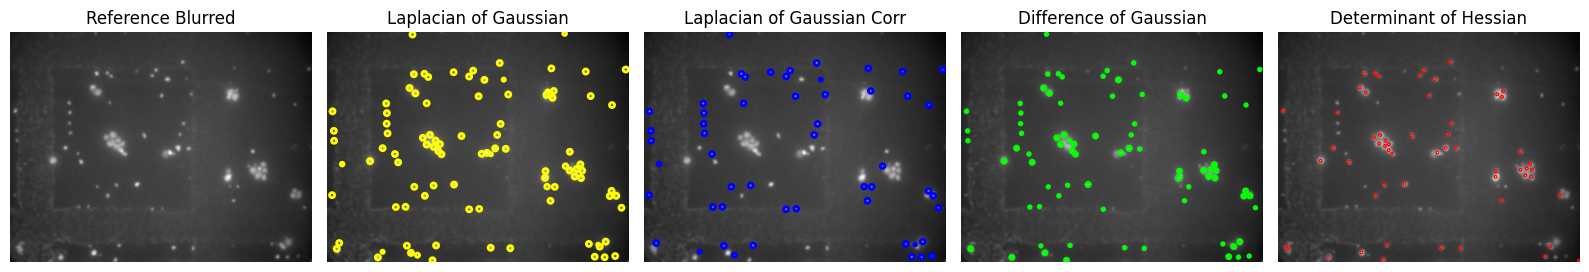

In [172]:
# visualization of the result
tresh = (np.max(corr_img_gauss) - np.min(corr_img_gauss)) / 2

ref = []

blobs_log = blob_log(corr_img_gauss, min_sigma=sigma_Gl*sqrt(2)/2, max_sigma=sigma_Gl*sqrt(2), num_sigma=40, threshold=.01, threshold_rel=tresh, exclude_border=True)
blobs_log = rois
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
blobs_log2 = rois2

blobs_log2[:, 2] = blobs_log2[:, 2] * sqrt(2)

blobs_dog = blob_dog(corr_img_gauss, min_sigma=sigma_Gl*sqrt(2)/2, max_sigma=sigma_Gl * 1.2, threshold=.01, threshold_rel=tresh, exclude_border=True)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(corr_img_gauss, min_sigma=1, max_sigma=5, num_sigma=10, threshold=.006, threshold_rel=tresh)

blobs_list = [ref, blobs_log, blobs_log2, blobs_dog, blobs_doh]
colors = ['pink', 'yellow','blue', 'lime', 'red']
titles = ['Reference Blurred', 'Laplacian of Gaussian', 'Laplacian of Gaussian Corr', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 5, figsize=(16, 4), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(corr_img_gauss, cmap='gray')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

Test bead:

onePil = stack[:, round(rois2[12,0]), round(rois2[12,1])]
rois2[0,1]

onePil_filtered = scipy.ndimage.gaussian_filter1d(onePil, sigma_Gl*2, mode = 'reflect')

max_pil = np.max(onePil_filtered)


easy way:

def find_peak(arr):
    max_val = max(arr)  # Find the highest value in the array
    max_idx = [i for i, value in enumerate(arr) if value == max_val]  # Find all indices with the highest value

    # Find the index of the middle occurrence if there are multiple highest values
    middle_idx = max_idx[len(max_idx) // 2]

    return middle_idx

middle_highest_index = find_peak(onePil_filtered)

hard way:

# Gaussian function with baseline
def gaussian(x, mu, sigma, A, baseline):
    return baseline + A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit curve to data
x = np.arange(len(onePil_filtered))
params, _ = curve_fit(gaussian, x, onePil_filtered, p0=[len(onePil_filtered)//2, sigma_Gl*2, sigma_Gl*3, statistics.mode(onePil_filtered)])

# Plotting
plt.plot(onePil, label='orig_Data')
plt.plot(x, onePil_filtered, label='filtered_Data')
plt.plot(x, gaussian(x, *params), label='Gaussian Fit')
plt.legend()
plt.show()

peak_position = params[0]

In [173]:
# for every roi, go through the z-dimension,  filter it with a gaussian and fit a gaussian
# mu is the position of the peak, sigma is the standard deviation (about half the width)
# A is the max height of the curve, baseline is the height

beads_z = []

def gaussian(x, mu, sigma, A, baseline):
    return baseline + A * np.exp(-(x - mu)**2 / (2 * sigma**2))

for i in range(len(rois2)):
    beads_z.append(stack[:, round(rois2[i,0]), round(rois2[i,1])])

peaks_x_y_z =[]
for i in range(len(beads_z)):
    curr_bead = beads_z[i]
    curr_bead_filtered = scipy.ndimage.gaussian_filter1d(curr_bead, sigma_Gl*2, mode = 'reflect')

    x = np.arange(len(curr_bead_filtered))
    params, _ = curve_fit(gaussian, x, curr_bead_filtered, p0=[len(curr_bead_filtered)//2, sigma_Gl*sqrt(2), sigma_Gl*3, statistics.mode(curr_bead_filtered)])
    print(params)
    peaks_x_y_z.append([round(rois2[i,1]), round(rois2[i,0]), round(params[0])])

[115.48971066  27.59970605  -6.91721866 136.78257049]
[ 39.51454845  70.87287603 -21.52058641 153.91406165]
[ 82.38868779  13.42440711  11.19196606 135.41082105]
[ 68.15248206  14.97491082  11.17320564 134.46665008]
[ 76.16219291  14.58849831  14.66790514 135.30357354]
[ 36.99776104 -28.80327345  -9.58206896 142.61921385]
[ 90.50898282  14.07756382  12.98844604 136.12714129]
[ 39.97067811 -27.24202031  -8.3150675  141.31820357]
[ 96.63129716  14.40940026  10.969103   136.57083847]
[ 80.7940902   15.69419415  13.14319996 134.53034216]
[ 75.95600252  13.39061557  13.56469529 136.75984372]
[ 92.02321775  14.0125384   15.02808031 135.34814247]
[ 63.92811783  13.72887614  13.63201841 135.21006396]
[128.24264187  32.15188223  -4.72431226 134.66121046]
[ 38.20270961  30.14037678  -7.15457705 141.18800717]
[ 76.7654457   14.12256375  13.89910919 136.86375166]
[116.78295322  30.79143393  -6.99768973 136.7397228 ]
[ 90.37477669  16.75600325  14.56394263 134.2486118 ]
[ 35.85122365  32.14510804  